In [2]:
import numpy as np
import networkx as nx
import networkx.generators.random_graphs as nxrg

In [3]:
def adjacency_gen(nnodes, undirected = False):
    adj = np.random.randint(2, size = (nnodes, nnodes), dtype = int)
    for i in range(nnodes):
        adj[i,i] = 0
    if(undirected):
        for i in range(nnodes):
            for j in range(i):
                adj[i,j] = adj[j,i]
    return adj

In [4]:
def flow_gen(adj, paths, nsample, Range=10, zero_centered=False, backflow = False, processed_paths = False, noise_level=0.2):
    '''
    generates flow samples based on eigenpaths with gaussian noise
    input:
    adj: adjacency matrix of graph, rows represent staring nodes, columns representing destination nodes
    paths: eigenpaths of a fixed length, 
        must be in the format [s1, d1, w1], [s2=d1, d2, w2], ... [sl=d(l-1), dl, wl]
        where s is the starting node of the edge, d is the ending node of the edge
        and w is the weight of each edge in the path
    nsample: number of samples generated
    backflow: allow edge adjacency matrix to have backflow, making it symetric
    noise: add gaussian noise or not
    
    output:
    sample: nsample * nedges np array
    edge_adj: edge adjacency matrix
    '''
    nEdges = 0
    #encode adjacency matrix into edge vector
    Edges = []
    for start in range(adj.shape[0]):
        for dest in range(adj.shape[0]):
            if(adj[start, dest] == 1):
                nEdges += 1
                Edges.append([start, dest])
    
    Paths = np.zeros((len(paths), nEdges), dtype = float)
    if processed_paths == False:
        for p in paths:
            prev_end = None
            for e in p:
                assert adj[e[0], e[1]] == 1 #all paths must exist
                assert prev_end is None or e[0] == prev_end #all paths must be valid
                prev_end = e[1]

        for p in range(len(paths)):
            for e in range(len(paths[0])):
                Paths[p, Edges.index(paths[p][e][0:2])] = paths[p][e][2]
    else:
        Paths = paths
    
    print("Edges:\n", Edges)
    print("Paths:\n", Paths)
    
    sample = np.zeros((nsample, nEdges), dtype = float)
    noiseless_sample = np.zeros((nsample, nEdges), dtype = float)
    for i in range(nsample):
        w = np.random.rand(len(paths))*Range #random weight for each path
        if zero_centered == True:
            w = w - Range/2
        sample[i,:] += w@Paths + Range * noise_level*np.random.randn(nEdges)
        noiseless_sample[i,:] += w@Paths
        
    #transform adjacency matrix into edge adjacecny matrix
    edge_adj = np.zeros((nEdges, nEdges), dtype = int)
    for e in range(nEdges):
        for i in range(adj.shape[0]):
            if(adj[Edges[e][1], i] == 1):
                edge_adj[e, Edges.index([Edges[e][1], i])] = 1
    
    if(backflow == True):
        for i in range(nEdges):
            for j in range(i):
                if(edge_adj[i.j] == 1 or edge_adj[j,i] == 1):
                    edge_adj[i,j] = 1 
                    edge_adj[j,i] = 1
    
    return sample, noiseless_sample, edge_adj, Paths

In [5]:
def path_gen(paths, weighted = False):
    results = []
    for pth in paths:
        print(pth)
        w_pth = []
        if weighted:
            weights = np.random.uniform(low = 5.0, high = 15.0, size = (len(pth)-1, ))
            for i in range(len(pth) - 1):
                w_pth.append([pth[i], pth[i+1], int(weights[i]) ])
        else:
            for i in range(len(pth) - 1):
                w_pth.append([pth[i], pth[i+1], 1 ])
            
        results.append(w_pth)
    return results

In [13]:
G = adjacency_gen(10, undirected = False)
print(G)

[[0 1 1 0 1 1 1 1 0 0]
 [0 0 0 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 1 0 0 1]
 [0 0 1 0 1 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 1]
 [0 1 1 0 1 1 0 1 0 1]
 [0 1 0 0 0 1 0 0 0 0]]


In [52]:
gnp = nxrg.fast_gnp_random_graph(30, 0.3, seed=None, directed=False)
gnp_G = nx.adjacency_matrix(gnp).toarray()
print(gnp_G)

[[0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0]
 [1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0]
 [0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0]
 [1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1]
 [1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0]
 [1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1]
 [1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0

In [47]:
swg = nxrg.newman_watts_strogatz_graph(10, 4, 0.3)
swg_G = nx.adjacency_matrix(swg).toarray()
print(swg_G)

[[0 1 1 0 0 1 0 0 1 1]
 [1 0 1 1 1 0 0 0 0 1]
 [1 1 0 1 1 0 0 0 0 0]
 [0 1 1 0 1 1 0 1 0 0]
 [0 1 1 1 0 1 1 1 1 0]
 [1 0 0 1 1 0 1 1 1 0]
 [0 0 0 0 1 1 0 1 1 1]
 [0 0 0 1 1 1 1 0 1 1]
 [1 0 0 0 1 1 1 1 0 1]
 [1 1 0 0 0 0 1 1 1 0]]


In [8]:
sfg = nxrg.barabasi_albert_graph(100,2)
sfg_G = nx.adjacency_matrix(sfg).toarray()
print(sfg_G)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
G = np.load('graph.npy')
print(G)
loaded_paths = np.load('paths.npy')
print(loaded_paths)
restored_path = np.nonzero(loaded_paths)
print(restored_path)

[[0 1 1 0 0 1 0 0 1 1]
 [1 0 1 1 1 0 1 1 0 1]
 [1 1 0 1 1 1 0 1 0 0]
 [0 1 1 0 1 1 0 0 0 1]
 [0 1 1 1 0 1 1 0 0 0]
 [1 0 1 1 1 0 1 1 0 0]
 [0 1 0 0 1 1 0 1 1 0]
 [0 1 1 0 0 1 1 0 1 1]
 [1 0 0 0 0 0 1 1 0 1]
 [1 1 0 1 0 0 0 1 1 0]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0.]]
(array([0, 0, 0, 0, 1, 1, 1, 1]), array([ 6, 14, 20, 27,  3,  5, 42, 47]))


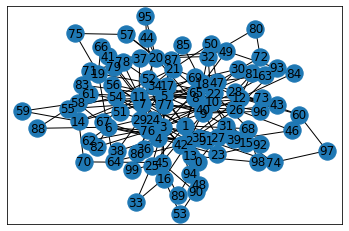

In [10]:
#DiG = nx.from_numpy_matrix(gnp, create_using=nx.DiGraph())
DiG = sfg
nx.draw_networkx(DiG, with_label = True) 

In [34]:
G = sfg_G
print(nx.diameter(DiG))
print(nx.shortest_path(DiG, 88, 15))

5
[88, 6, 2, 15]


In [7]:
swg_pth = path_gen([[8,7,1,2,4], 
                    [8,7,1,3,9]])
print(swg_pth)

[8, 7, 1, 2, 4]
[8, 7, 1, 3, 9]
[[[8, 7, 1], [7, 1, 1], [1, 2, 1], [2, 4, 1]], [[8, 7, 1], [7, 1, 1], [1, 3, 1], [3, 9, 1]]]


In [82]:
spaths = nx.all_simple_paths(sfg, 4, 3)
print(list(spaths))

[[4, 2, 0, 3], [4, 2, 0, 6, 3], [4, 2, 3], [4, 2, 5, 3], [4, 2, 7, 0, 3], [4, 2, 7, 0, 6, 3], [4, 2, 8, 3], [4, 2, 9, 3], [4, 3]]


In [28]:
sfg_pth = path_gen([[5, 1, 7, 4, 3, 9],                     
                    [10, 5,3, 4, 2,15],                     
                    [60,97,74,15,2,6,88]])
print(sfg_pth)

[5, 1, 7, 4, 3, 9]
[10, 5, 3, 4, 2, 15]
[60, 97, 74, 15, 2, 6, 88]
[[[5, 1, 1], [1, 7, 1], [7, 4, 1], [4, 3, 1], [3, 9, 1]], [[10, 5, 1], [5, 3, 1], [3, 4, 1], [4, 2, 1], [2, 15, 1]], [[60, 97, 1], [97, 74, 1], [74, 15, 1], [15, 2, 1], [2, 6, 1], [6, 88, 1]]]


In [66]:
npg_pth = path_gen([[12,0,11,8,20], 
                    [8,12,29,26,1],
                    [13,21,5,2,7]])
print(npg_pth)

[12, 0, 11, 8, 20]
[8, 12, 29, 26, 1]
[13, 21, 5, 2, 7]
[[[12, 0, 1], [0, 11, 1], [11, 8, 1], [8, 20, 1]], [[8, 12, 1], [12, 29, 1], [29, 26, 1], [26, 1, 1]], [[13, 21, 1], [21, 5, 1], [5, 2, 1], [2, 7, 1]]]


In [36]:
flows, noiseless_flows, edge_adj, paths = flow_gen(sfg_G, sfg_pth, 2000, Range=2, zero_centered=True, \
                                                   processed_paths = False, noise_level=0.3)

Edges:
 [[0, 2], [0, 3], [0, 31], [0, 89], [1, 2], [1, 5], [1, 7], [1, 8], [1, 23], [1, 25], [1, 34], [1, 36], [1, 39], [1, 42], [1, 65], [1, 68], [1, 91], [2, 0], [2, 1], [2, 3], [2, 4], [2, 6], [2, 15], [2, 16], [2, 26], [2, 47], [2, 48], [2, 94], [3, 0], [3, 2], [3, 4], [3, 5], [3, 9], [3, 11], [3, 13], [3, 16], [3, 17], [3, 18], [3, 25], [3, 27], [3, 28], [3, 34], [3, 35], [3, 45], [3, 51], [3, 52], [3, 54], [3, 62], [3, 77], [3, 82], [3, 91], [3, 99], [4, 2], [4, 3], [4, 6], [4, 7], [4, 23], [4, 36], [4, 38], [4, 39], [4, 67], [5, 1], [5, 3], [5, 8], [5, 9], [5, 10], [5, 12], [5, 18], [5, 22], [5, 47], [5, 51], [5, 56], [5, 58], [5, 65], [5, 83], [5, 87], [6, 2], [6, 4], [6, 19], [6, 29], [6, 58], [6, 62], [6, 64], [6, 76], [6, 82], [6, 88], [7, 1], [7, 4], [7, 13], [7, 14], [7, 26], [7, 40], [7, 55], [7, 56], [7, 61], [7, 69], [7, 71], [7, 78], [7, 79], [8, 1], [8, 5], [8, 17], [8, 24], [8, 81], [9, 3], [9, 5], [9, 10], [9, 11], [9, 12], [9, 20], [9, 22], [9, 27], [9, 43], [9, 45

In [71]:
print('noiseless:\n',noiseless_flows[0:1])
print('with noise:\n',flows[0:1])
noiseless_flows.shape

noiseless:
 [[ 0.          0.          0.         -0.23747479  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.99925106  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.99925106  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         -0.43117308  0.          0.
  -0.23747479  0.          0.          0.          0.          0

(2000, 310)

In [37]:
np.save('flows.npy', flows)
np.save('noiseless_flows.npy', noiseless_flows)
np.save('adj.npy', edge_adj)
np.save('paths.npy', paths)
np.save('graph.npy', G)

In [16]:
print(noiseless_flows[0])

[ 0.          0.          0.          0.          0.          0.
 48.98215367  0.          0.          0.          0.          0.
  0.          0.         48.98215367  0.          0.          0.
  0.          0.         48.98215367  0.          0.          0.
  0.          0.          0.         48.98215367  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
